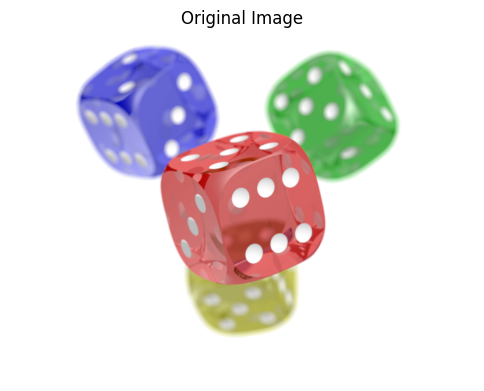

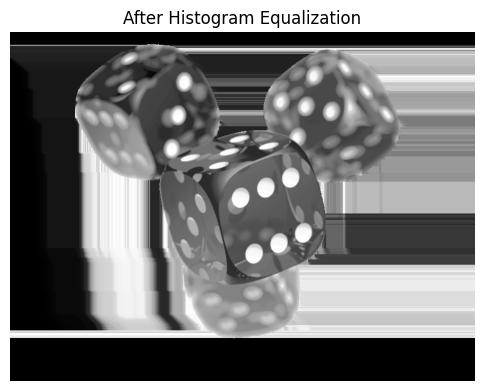

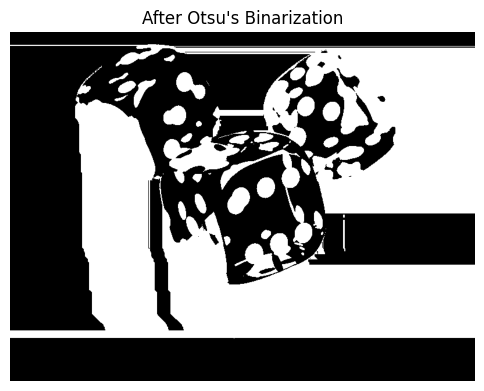

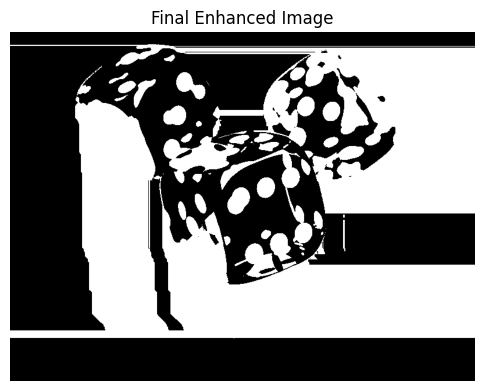

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Function to fetch an image from a URL and convert it to a numpy array
def fetch_image(url):
    response = requests.get(url)
    image = plt.imread(BytesIO(response.content))
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    return image

# Function to display an image
def display_image(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Grayscale conversion helper
def to_grayscale(image):
    if len(image.shape) == 3:  # If RGB
        return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    return image

# 1. Histogram Equalization
def histogram_equalization(image):
    image = to_grayscale(image)
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()  # Cumulative Distribution Function
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    equalized_image = cdf_normalized[image].astype(np.uint8)
    return equalized_image

# 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
def clahe(image, clip_limit=40, grid_size=8):
    image = to_grayscale(image)
    h, w = image.shape
    grid_h, grid_w = h // grid_size, w // grid_size
    clahe_image = np.zeros_like(image)

    for i in range(grid_size):
        for j in range(grid_size):
            start_i, end_i = i * grid_h, (i + 1) * grid_h
            start_j, end_j = j * grid_w, (j + 1) * grid_w
            tile = image[start_i:end_i, start_j:end_j]

            # Histogram Equalization for the tile
            hist, _ = np.histogram(tile.flatten(), bins=256, range=[0, 256])
            cdf = hist.cumsum()
            cdf_clipped = np.clip(cdf, 0, clip_limit).astype(np.float32)
            cdf_clipped = (cdf_clipped - cdf_clipped.min()) * 255 / (cdf_clipped.max() - cdf_clipped.min())
            tile_equalized = cdf_clipped[tile].astype(np.uint8)
            clahe_image[start_i:end_i, start_j:end_j] = tile_equalized

    return clahe_image

# 3. Gamma Correction
def gamma_correction(image, gamma):
    gamma_image = ((image / 255.0) ** gamma) * 255
    return np.clip(gamma_image, 0, 255).astype(np.uint8)

# 4. Otsu's Binarization
def otsu_binarization(image):
    image = to_grayscale(image)
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    total_pixels = image.size
    current_max = 0
    threshold = 0
    sum_total = np.sum(np.arange(256) * hist)

    sum_bg = 0
    weight_bg = 0
    weight_fg = 0

    for t in range(256):
        weight_bg += hist[t]
        if weight_bg == 0:
            continue
        weight_fg = total_pixels - weight_bg
        if weight_fg == 0:
            break

        sum_bg += t * hist[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg

        # Calculate Between-Class Variance
        between_class_variance = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        # Find the maximum variance
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = t

    # Apply the threshold to binarize the image
    binary_image = (image > threshold).astype(np.uint8) * 255
    return binary_image

def final_image_enhancement(image):
    display_image("Original Image", image)

    # Step 1: Histogram Equalization
    hist_eq_image = histogram_equalization(image)
    display_image("After Histogram Equalization", hist_eq_image)

    # Step 2: Otsu's Binarization
    otsu_image = otsu_binarization(hist_eq_image)
    display_image("After Otsu's Binarization", otsu_image)

    # Step 3: Gamma Correction
    final_image = gamma_correction(otsu_image, gamma=2.2)
    display_image("Final Enhanced Image", final_image)

    return final_image

# Main script
if __name__ == "__main__":
    # Replace with your image URL or uploaded file
    image_path = "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png"  # Uploaded image
    original_image = fetch_image(image_path)

    # Apply the final enhancement pipeline
    enhanced_image = final_image_enhancement(original_image)
